In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
from matplotlib import patches
from sklearn import metrics
# from pyswarm import pso

In [2]:
df = pd.read_csv('/home/fotis/DATA/Crimes_-_2001_to_present.csv', header=0)

In [3]:
df = df[(df['X Coordinate'] > 200000) & (df['Y Coordinate']>250000)]

In [4]:
s = df.sample(20000)

/home/fotis/anaconda3/envs/data_vis/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


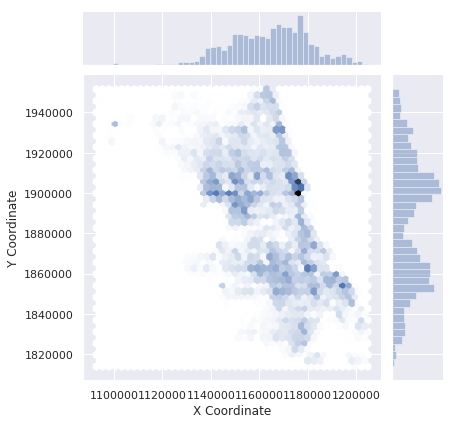

In [5]:
sns.jointplot(x='X Coordinate', y='Y Coordinate',data=s, kind='hex', )

In [6]:
s = s.dropna()

In [7]:
q = s[s['Primary Type'].isin(s.groupby('Primary Type').size().sort_values(ascending=False)[:10].index.tolist())]

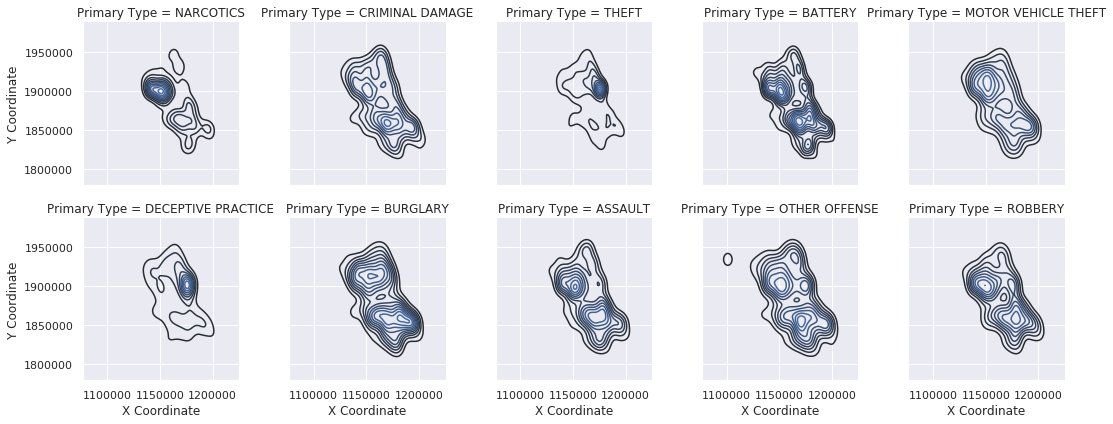

In [8]:
g = sns.FacetGrid(q, col="Primary Type",col_wrap=5)
g = (g.map(sns.kdeplot, "X Coordinate", "Y Coordinate")
    .add_legend())

In [9]:
MIN_x = s['X Coordinate'].min()
MAX_x = s['X Coordinate'].max()
MIN_y = s['Y Coordinate'].min()
MAX_y = s['Y Coordinate'].max()

In [10]:
data_space = s[['X Coordinate', 'Y Coordinate']].dropna().values
data_space[:,0] = (data_space[:,0] - MIN_x) / (MAX_x-MIN_x)
data_space[:,1] = (data_space[:,1] - MIN_y) / (MAX_y-MIN_y)

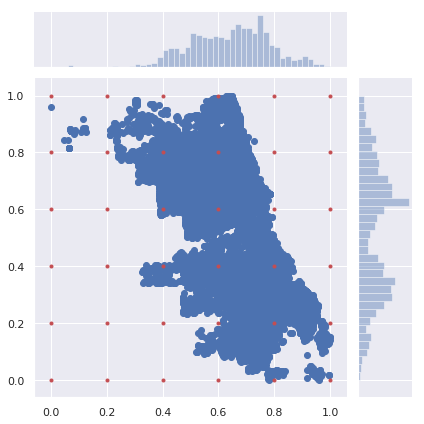

In [11]:
x = np.linspace(0,1, 6)
y = np.linspace(0,1, 6)
xx, yy = np.meshgrid(x,y)
g = sns.jointplot(x=data_space[:,0], y=data_space[:,1] )
g.ax_joint.plot(xx, yy, '.r')

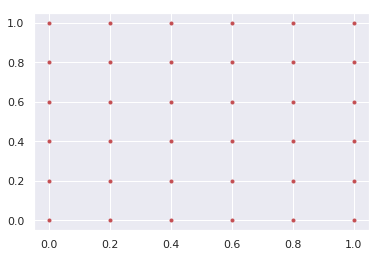

In [12]:
x_y = np.column_stack((xx.ravel(), yy.ravel()))
query_centers = []
cluster = 0
plt.plot(xx, yy, '.r')
S_x = 0.1*(np.std(data_space[:,0]))
S_y = 0.1*(np.std(data_space[:,1]))

while cluster!=xx.shape[0]**2:
    queries = np.random.multivariate_normal(x_y[cluster], np.array([[S_x,0],[0, S_y]]), size=400)
    query_centers.append(queries)
    cluster+=1
query_centers = np.array(query_centers).reshape(-1,2)

In [13]:
#Execute Query Function
def execute_query(q,r):
    q = data_space[np.where((data_space[:,0]<q[0]+r) & (data_space[:,0]>q[0]-r) & (data_space[:,1]<q[1]+r) & (data_space[:,1]>q[1]-r))]
    return q.shape[0]

In [14]:
RANGE = 0.01
ranges = np.random.uniform(low=RANGE, high=0.05, size=query_centers.shape[0])
queries = []
for q,r in zip(query_centers,ranges):
    queries.append([q[0], q[1],r, execute_query(q,r)])


In [18]:
#Visualise task
queries = np.array(queries)
sq = queries[queries[:,3]!=0]

In [19]:
sq = sq[np.random.randint(0, sq.shape[0], size=50)]

In [15]:
# np.savetxt('input/chicago_uniform_queries.csv',queries, delimiter=',')

In [2]:
# queries = np.loadtxt('input/chicago_uniform_queries.csv',delimiter=',')

24.0

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
     queries[:,:3], queries[:,3], test_size=0.2, random_state=0)

In [23]:
xgb1 = XGBRegressor(max_depth=5,n_estimators=150)
xgb1.fit(X_train, y_train)
print(np.sqrt(metrics.mean_squared_error(y_train, xgb1.predict(X_train))))
r2 = xgb1.score(X_test, y_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, xgb1.predict(X_test)))
print(r2)
print(rmse)

[11:08:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
23.70838480481539
0.9262491688500363
33.99351469949411


In [30]:
#Plot function 
param1 = np.linspace(0,1,100)
param2 = np.linspace(0,1,100)
# param3 = np.linspace(0.015, 0.035, 500)
param3 = np.ones(100)*0.025
XX,YY = np.meshgrid(param1,param2)
RR,BB = np.meshgrid(param1, param3)
ZZ = xgb1.predict(np.column_stack((XX.ravel(), YY.ravel(), RR.ravel())))

In [31]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
import copy

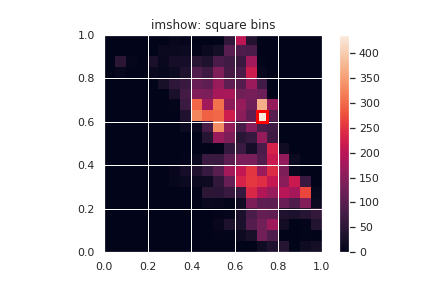

In [32]:
H, xedges, yedges = np.histogram2d(data_space[:,0], data_space[:,1], bins=(20, 20)) 
H = H.T
box_ix = np.unravel_index(np.argmax(H.T), H.T.shape)
x_l, x_h = xedges[box_ix[0]:box_ix[0]+2]
y_l, y_h = yedges[box_ix[1]:box_ix[1]+2]
fig = plt.figure()
ax = fig.add_subplot(111, title='imshow: square bins')
plt.imshow(H, interpolation='nearest', origin='low',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar()
ax.add_patch(patches.Rectangle((x_l, y_l),x_h-x_l,y_h-y_l ,fill=False,edgecolor='red',lw=3))


In [33]:
H[box_ix]

127.0

In [34]:
#Transform bin edges to centers
param1 = xedges[1:]-.025
param2 = yedges[1:]-.025
# param3 = np.linspace(0.015, 0.035, 500)
param3 = np.ones(param1.shape[0])*0.025
XX,YY = np.meshgrid(param1,param2)
RR,BB = np.meshgrid(param1, param3)
ZZ = xgb1.predict(np.column_stack((XX.ravel(), YY.ravel(), RR.ravel())))

In [35]:
ZZ = ZZ.reshape(param1.shape[0],param1.shape[0])

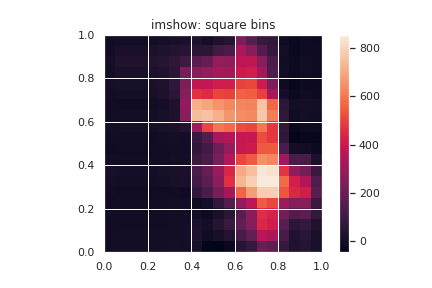

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111, title='imshow: square bins')
plt.imshow(ZZ, interpolation='nearest', origin='low',
        extent=[0, 1, 0, 1])
plt.colorbar()

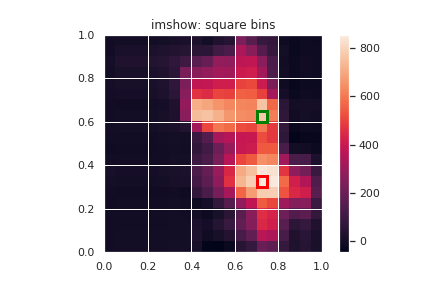

In [37]:
box_ix = np.unravel_index(np.argmax(ZZ), ZZ.shape)
x_l_a, x_h_a = XX[box_ix]-0.025, XX[box_ix]+0.025
y_l_a, y_h_a = YY[box_ix]-0.025, YY[box_ix]+0.025
fig = plt.figure()
ax = fig.add_subplot(111, title='imshow: square bins')
plt.imshow(ZZ, interpolation='nearest', origin='low',
        extent=[0, 1, 0, 1])
plt.colorbar()
ax.add_patch(patches.Rectangle((x_l_a, y_l_a),x_h_a-x_l_a,y_h_a-y_l_a ,fill=False,edgecolor='red',lw=3))
ax.add_patch(patches.Rectangle((x_l, y_l),x_h-x_l,y_h-y_l ,fill=False,edgecolor='green',lw=3))


<h3>Using GSO and updated Objective</h3>

In [38]:
import copy
from Optimization_Methods.GlowWorm import GlowWorm

In [50]:
q3 = np.percentile(queries[:,-1],75)

In [69]:
np.random.seed(30)

In [73]:
def objective_density(X):
    assert X.shape[1]==3
    res = np.log(xgb1.predict(X) - q3) - 4*np.sum(np.log(1+4*X[:,-1].reshape(1,-1)),axis=0) 
    res[np.isnan(res)] = -np.inf
    return res
gw = GlowWorm(objective_density, dimensions=3, nt=10, iter_max=750, glowworms=150, r0=0.17)
initial = copy.copy(gw.X)
pos = gw.optimize()

/home/fotis/.local/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


In [74]:
w_pos = pos[np.argsort(-objective_density(pos))][:20]

/home/fotis/.local/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


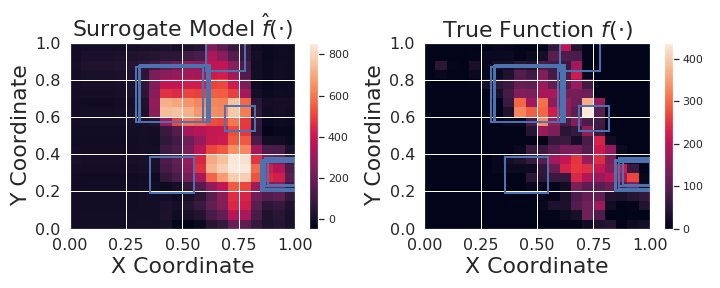

In [75]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
plt.imshow(ZZ, interpolation='nearest', origin='low', aspect='auto',
        extent=[0, 1, 0, 1])
plt.colorbar()
# ax.add_patch(patches.Rectangle((x_l_a, y_l_a),x_h_a-x_l_a,y_h_a-y_l_a ,fill=False,edgecolor='red',lw=3))
# ax.add_patch(patches.Rectangle((x_l, y_l),x_h-x_l,y_h-y_l ,fill=False,edgecolor='green',lw=3))
for x in w_pos:
    ax.add_patch(patches.Rectangle((x[0]-x[2], x[1]-x[2]),2*x[2], 2*x[2] ,fill=False,edgecolor='b',lw=2))
ax.set_xlabel('X Coordinate',fontsize=22)
ax.set_ylabel('Y Coordinate',fontsize=22)
ax.set_title('Surrogate Model $\hat{f}(\cdot)$', fontsize=22)
ax.tick_params(labelsize=16)

ax = fig.add_subplot(122, title='True Mapping')

plt.imshow(H, interpolation='nearest', origin='low',aspect='auto',
        extent=[0, 1, 0, 1])
plt.colorbar()
for x in w_pos:
    ax.add_patch(patches.Rectangle((x[0]-x[2], x[1]-x[2]),2*x[2], 2*x[2] ,fill=False,edgecolor='b',lw=2))
ax.set_xlabel('X Coordinate',fontsize=22)
ax.set_ylabel('Y Coordinate',fontsize=22)
ax.set_title('True Function ${f}(\cdot)$', fontsize=22)
ax.tick_params(labelsize=16)
# plt.axis('equal')
plt.tight_layout()
# plt.savefig('output/example_crimes.eps',format='eps',dpi=300)